In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('PJME_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

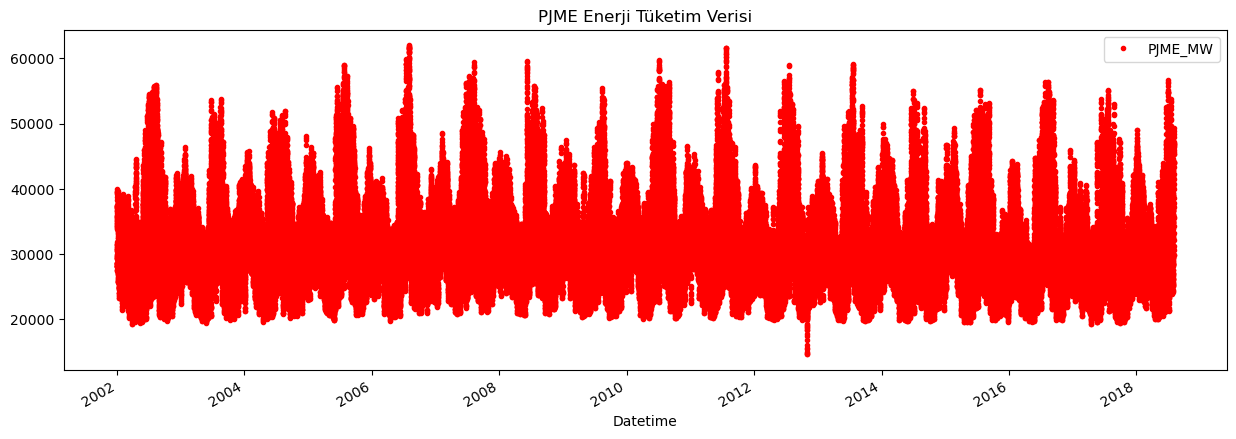

In [30]:
df.plot(style='.', figsize=(15, 5), color='red', title='PJME Enerji Tüketim Verisi')
plt.show()

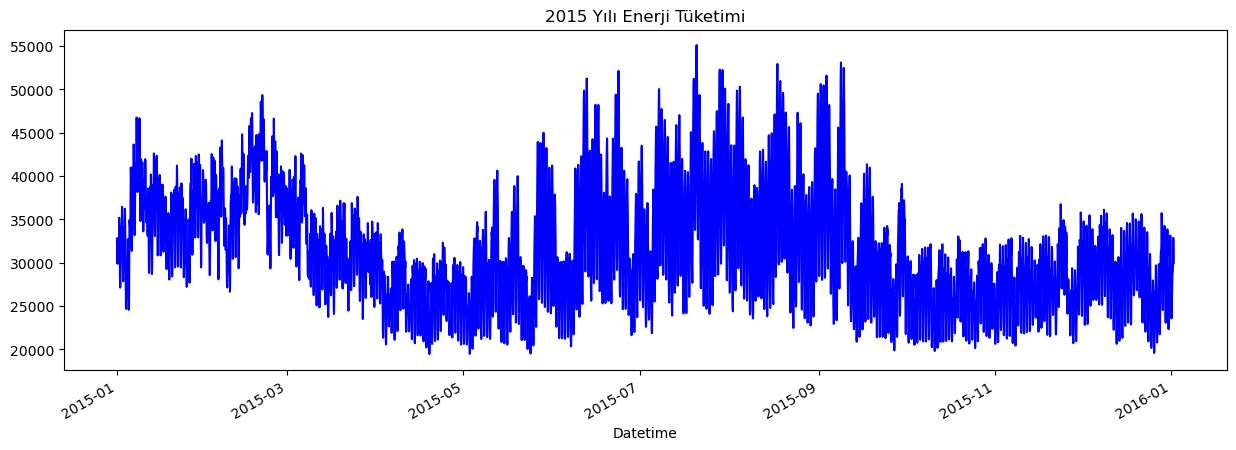

In [31]:
df = df.sort_index()

df_2015 = df.loc['2015-01-01':'2016-01-01']

df_2015['PJME_MW'].plot(figsize=(15, 5), color='blue', title='2015 Yılı Enerji Tüketimi')
plt.show()

In [32]:
df['hour'] = df.index.hour      
df['dayofweek'] = df.index.dayofweek 
df['month'] = df.index.month      
df['quarter'] = df.index.quarter  
df['year'] = df.index.year        
print(df.head())

                     PJME_MW  hour  dayofweek  month  quarter  year
Datetime                                                           
2002-01-01 01:00:00  30393.0     1          1      1        1  2002
2002-01-01 02:00:00  29265.0     2          1      1        1  2002
2002-01-01 03:00:00  28357.0     3          1      1        1  2002
2002-01-01 04:00:00  27899.0     4          1      1        1  2002
2002-01-01 05:00:00  28057.0     5          1      1        1  2002


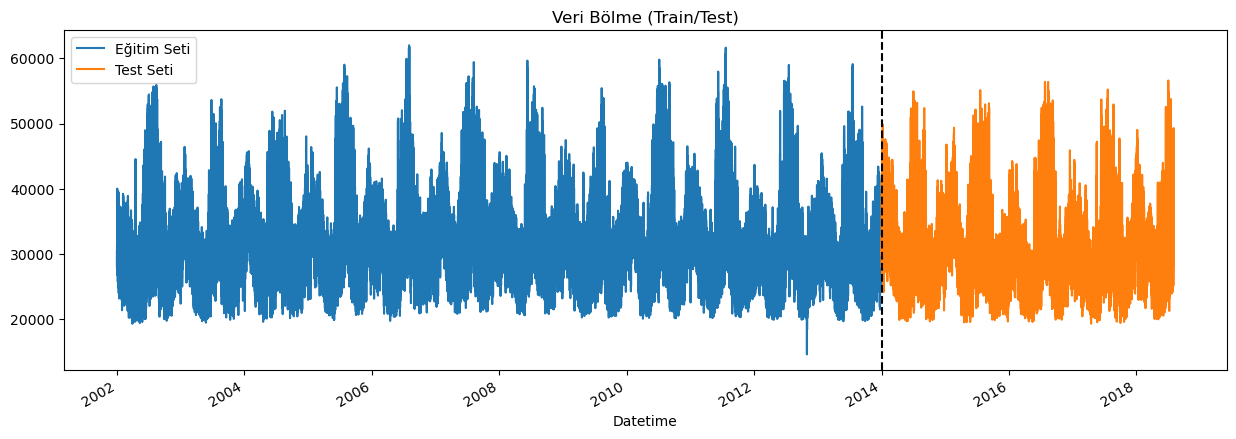

In [33]:
train = df.loc[df.index < '01-01-2014']
test = df.loc[df.index >= '01-01-2014']

fig, ax = plt.subplots(figsize=(15, 5))

train['PJME_MW'].plot( ax=ax, label='Eğitim Seti (Geçmiş)', title='Veri Bölme (Train/Test)')
test['PJME_MW'].plot( ax=ax, label='Test Seti (Gelecek)')

ax.axvline('01-01-2014', color='black', ls='--')
ax.legend(['Eğitim Seti', 'Test Seti'])
plt.show()

In [34]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

print(f"Eğitim için {X_train.shape[0]} satır verimiz var.")
print(f"Test için {X_test.shape[0]} satır verimiz var.")

Eğitim için 105166 satır verimiz var.
Test için 40200 satır verimiz var.


In [35]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:6432.34905	validation_1-rmse:6410.28888
[100]	validation_0-rmse:4013.99675	validation_1-rmse:4324.24020
[200]	validation_0-rmse:3422.78928	validation_1-rmse:3894.75634
[300]	validation_0-rmse:3224.18687	validation_1-rmse:3761.22543
[400]	validation_0-rmse:3121.42800	validation_1-rmse:3708.99744
[500]	validation_0-rmse:3050.35035	validation_1-rmse:3701.45195
[531]	validation_0-rmse:3030.44764	validation_1-rmse:3704.63629


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


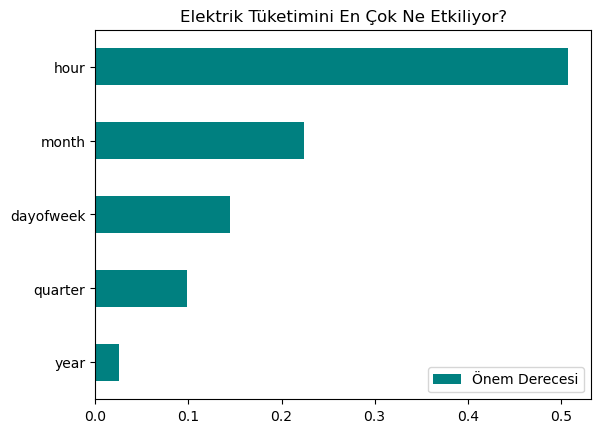

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Önem Derecesi'])

fi.sort_values('Önem Derecesi').plot(kind='barh', title='Elektrik Tüketimini En Çok Ne Etkiliyor?', color='teal')
plt.show()

C:\Users\keski\AppData\Local\Temp\ipykernel_25104\3624846037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = predictions


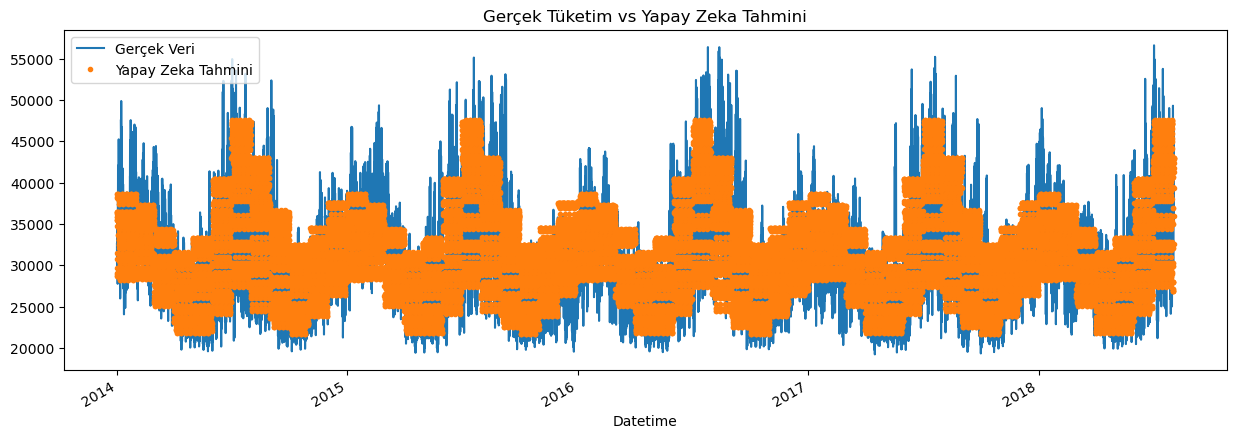

In [37]:
predictions = reg.predict(X_test)

test['prediction'] = predictions

ax = test[['PJME_MW']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Gerçek Veri', 'Yapay Zeka Tahmini'])
plt.title('Gerçek Tüketim vs Yapay Zeka Tahmini')
plt.show()

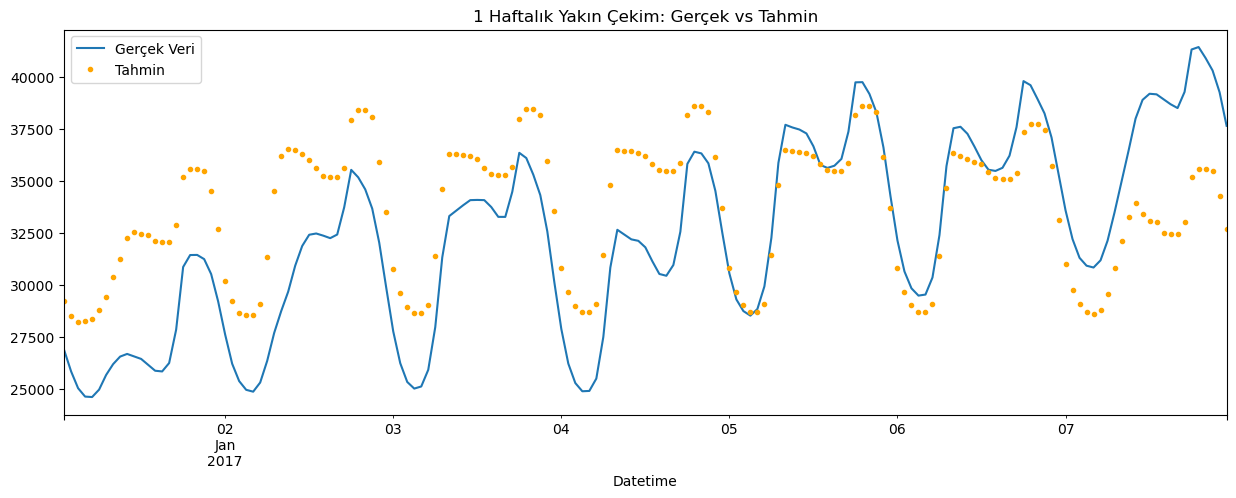

In [38]:
f, ax = plt.subplots(figsize=(15, 5))

test.loc[(test.index > '01-01-2017') & (test.index < '01-08-2017')]['PJME_MW'] \
    .plot(ax=ax, title='1 Haftalık Yakın Çekim: Gerçek vs Tahmin')

test.loc[(test.index > '01-01-2017') & (test.index < '01-08-2017')]['prediction'] \
    .plot(ax=ax, style='.', color='orange')

plt.legend(['Gerçek Veri', 'Tahmin'])
plt.show()

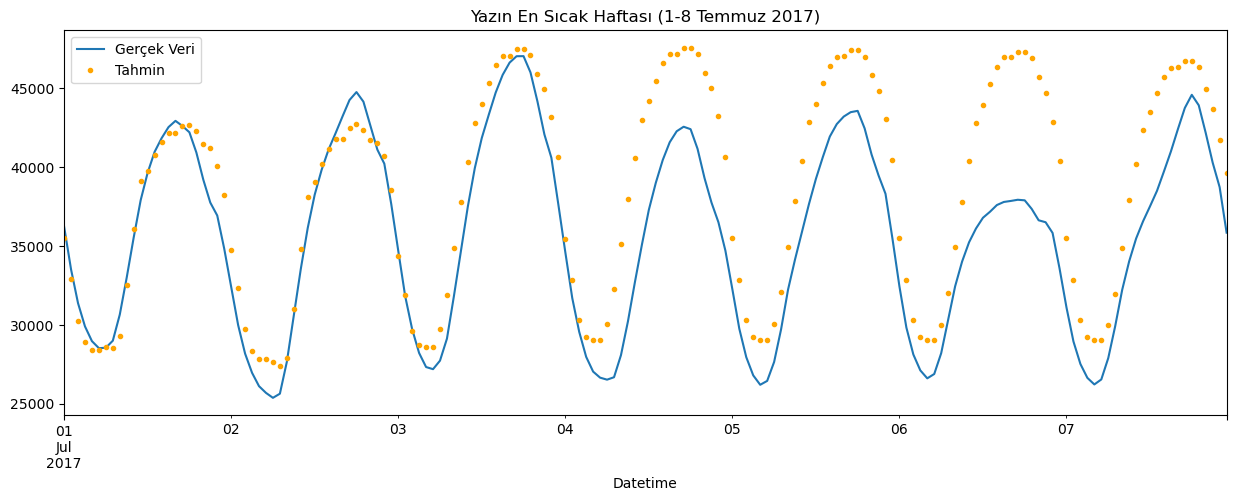

In [39]:
f, ax = plt.subplots(figsize=(15, 5))

start_date = '2017-07-01'  
end_date = '2017-07-08'  

mask = (test.index >= start_date) & (test.index < end_date)
test.loc[mask]['PJME_MW'].plot(ax=ax, title='Yazın En Sıcak Haftası (1-8 Temmuz 2017)')
test.loc[mask]['prediction'].plot(ax=ax, style='.', color='orange')

plt.legend(['Gerçek Veri', 'Tahmin'])
plt.show()